In [6]:
!pip install polars
!pip install fastparquet
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 48.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [7]:
import numpy as np 
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
import random
from tqdm import tqdm
import pickle

from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

## 任务分析:
### 训练数据：
- 行星数量：673颗行星。
- 预测label：需要预测的目标数量为283个(光谱分解)——多输出回归。

### 测试数据：
- 约800颗隐藏的行星用于测试。

In [8]:
train_adc_info = pd.read_csv('./input/ariel-data-challenge-2024/train_adc_info.csv',index_col='planet_id')
# test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',index_col='planet_id')
train_labels = pd.read_csv('./input/ariel-data-challenge-2024/train_labels.csv',index_col='planet_id')
wavelengths = pd.read_csv('./input/ariel-data-challenge-2024/wavelengths.csv')
axis_info = pd.read_parquet('./input/ariel-data-challenge-2024/axis_info.parquet')

## FGS1数据观察（暂时不用校准文件）
### 数据描述
- 每个文件包含135,000行图像，图像以0.1秒的时间间隔拍摄。每行是一个32x32的单波长图像。
### 取100468857号行星的FGS1数据进行观察

In [11]:
# 获取所有行星 ID 列表
planet_ids = train_adc_info.index.tolist()

# 随机从中选择 9 个行星 ID
random_ids = random.sample(planet_ids, 9)
print("从现有行星 ID 中随机生成的 9 个 ID：", random_ids)

# 使用 random_ids 遍历处理
for planet_id in random_ids:
    try:
        f_signal = pd.read_parquet(f'./input/ariel-data-challenge-2024/train/{planet_id}/FGS1_signal.parquet')
        print(f"行星 {planet_id} 的数据：")
        print(f_signal)
    except FileNotFoundError:
        print(f"行星 {planet_id} 的数据文件未找到！")

从现有行星 ID 中随机生成的 9 个 ID： [1598287691, 2026728872, 585737420, 637988352, 1971619027, 1236398737, 2675006243, 1754973667, 3963820198]
行星 1598287691 的数据：
        column_0  column_1  column_2  column_3  column_4  column_5  column_6  \
0            297       313       323       315       308       304       298   
1            298       305       319       320       317       320       312   
2            337       311       321       312       320       297       309   
3            317       305       325       308       297       313       315   
4            327       308       318       322       308       313       298   
...          ...       ...       ...       ...       ...       ...       ...   
134995       310       299       306       311       301       299       315   
134996       315       280       298       321       315       298       289   
134997       317       298       315       315       323       321       305   
134998       316       311       300       308    

In [12]:
f_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_1014,column_1015,column_1016,column_1017,column_1018,column_1019,column_1020,column_1021,column_1022,column_1023
0,351,360,333,353,330,340,353,341,348,373,...,363,326,352,350,323,350,353,337,333,356
1,361,358,376,374,356,345,366,364,367,379,...,364,350,355,355,338,327,359,358,373,355
2,342,348,355,365,342,377,342,377,348,326,...,359,340,362,340,365,381,343,361,360,338
3,342,337,363,344,374,346,367,358,403,363,...,325,365,353,356,350,363,318,305,354,379
4,333,378,348,334,358,362,326,342,346,381,...,361,369,320,322,365,340,333,376,374,371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134995,355,360,361,351,354,359,381,396,342,391,...,336,339,355,368,355,368,358,326,349,377
134996,345,357,349,364,344,350,364,364,347,352,...,348,365,339,374,362,340,358,377,358,362
134997,344,361,357,355,374,377,370,332,374,364,...,354,354,351,351,356,369,341,332,331,354
134998,363,364,376,345,344,337,339,350,355,374,...,349,364,337,347,340,368,360,392,391,369


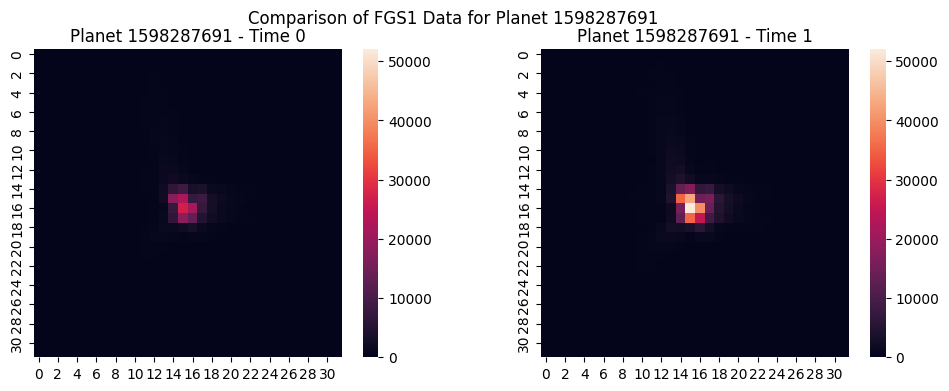

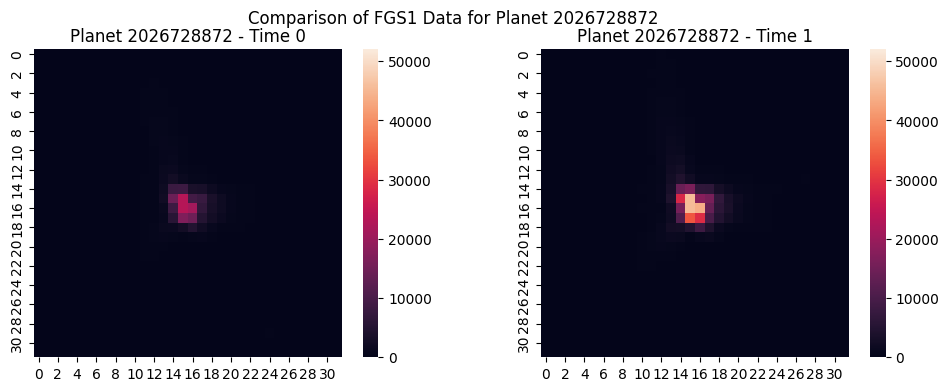

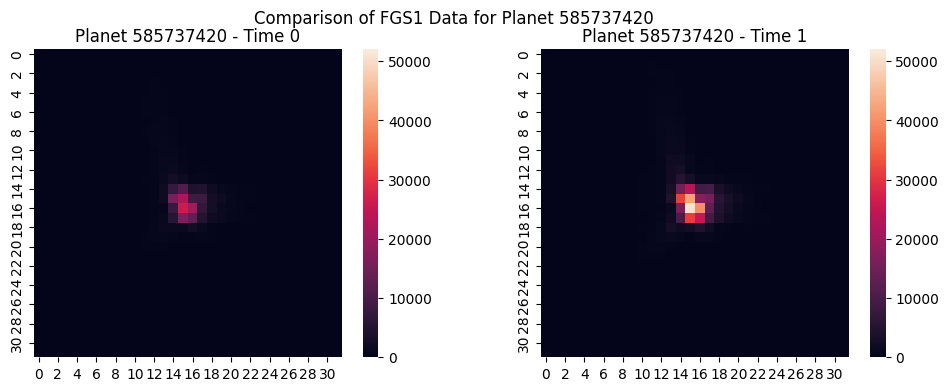

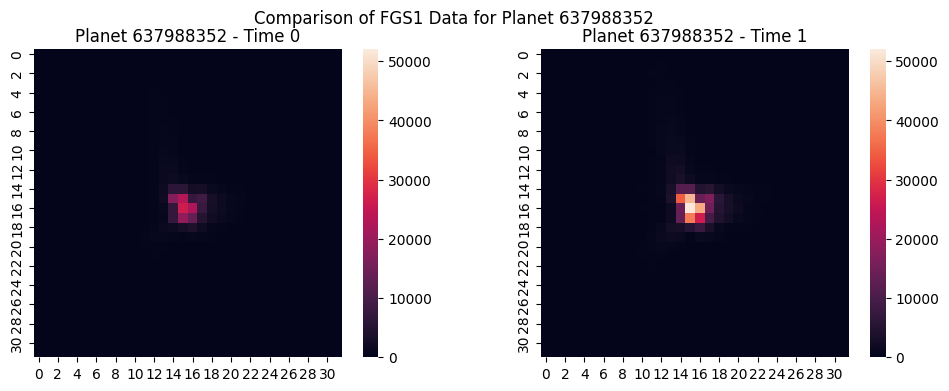

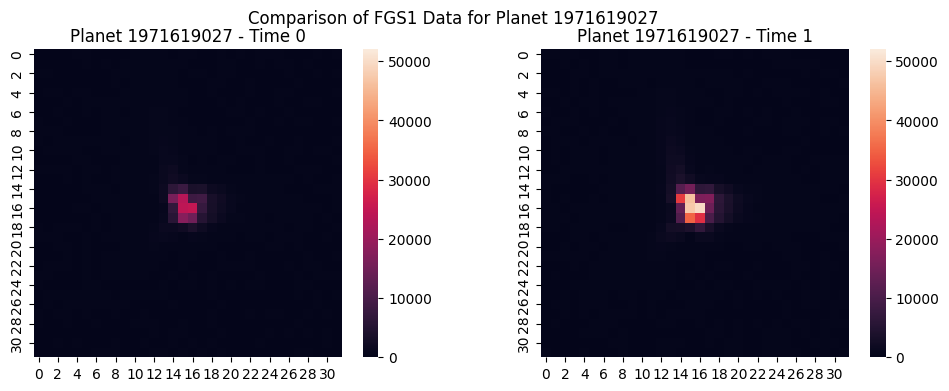

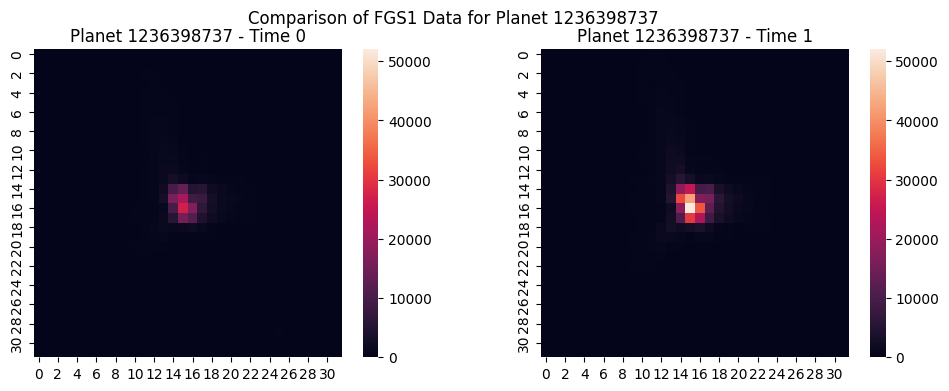

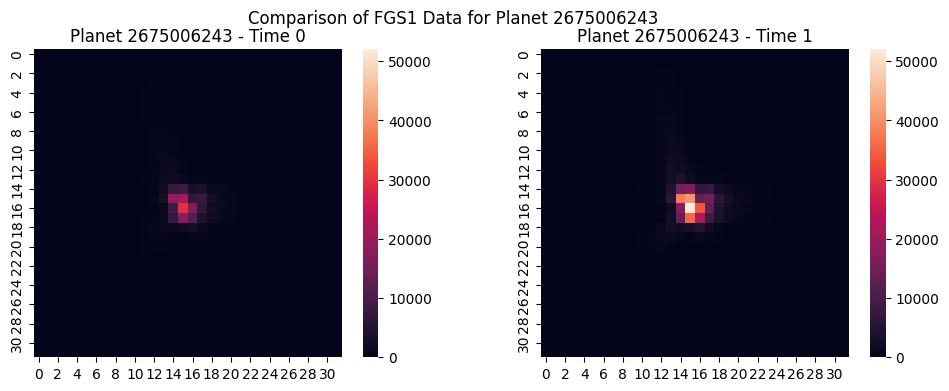

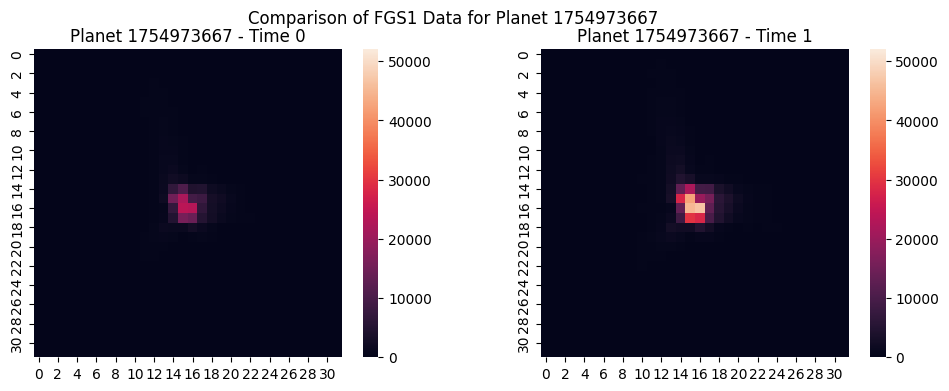

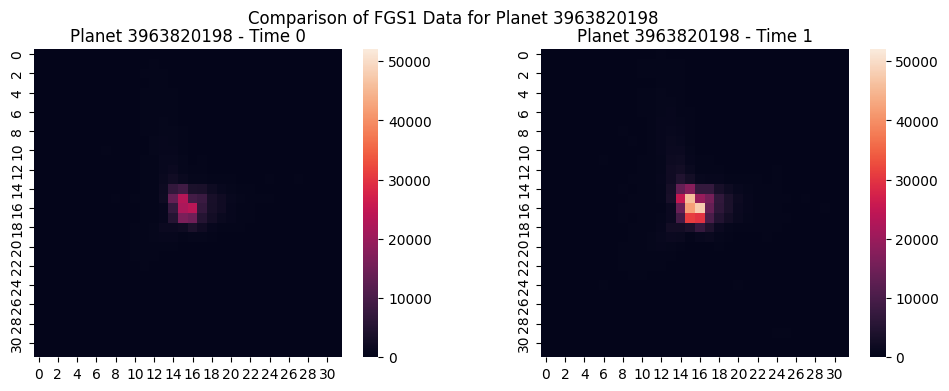

In [14]:
# 遍历每个随机行星
for planet_id in random_ids:
    try:
        # 读取对应行星的 FGS1 数据
        f_signal = pd.read_parquet(f'./input/ariel-data-challenge-2024/train/{planet_id}/FGS1_signal.parquet')
        
        # 可视化第 0 时刻和第 1 时刻的数据
        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        sns.heatmap(f_signal.iloc[0].values.reshape(32, 32), ax=ax1, vmin=0, vmax=52000)
        ax1.set_aspect('equal')
        ax1.set_title(f"Planet {planet_id} - Time 0")

        sns.heatmap(f_signal.iloc[1].values.reshape(32, 32), ax=ax2, vmin=0, vmax=52000)
        ax2.set_aspect('equal')
        ax2.set_title(f"Planet {planet_id} - Time 1")

        plt.suptitle(f'Comparison of FGS1 Data for Planet {planet_id}')
        plt.show()
        
    except FileNotFoundError:
        print(f"行星 {planet_id} 的数据文件未找到！")

In [17]:
planet_id = 14485303
f_signal = pd.read_parquet(f'./input/ariel-data-challenge-2024/train/{planet_id}/FGS1_signal.parquet')
f_signal

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_1014,column_1015,column_1016,column_1017,column_1018,column_1019,column_1020,column_1021,column_1022,column_1023
0,315,313,308,301,311,315,307,298,315,320,...,304,317,304,284,321,312,314,340,297,310
1,286,325,303,309,307,332,300,299,334,319,...,306,315,304,302,312,327,318,270,299,302
2,304,292,303,318,313,308,300,316,335,356,...,329,330,305,314,302,291,314,323,315,310
3,312,300,299,347,300,317,320,319,333,350,...,316,313,310,294,319,298,310,291,287,319
4,324,313,300,334,326,312,319,305,341,317,...,294,300,313,326,334,316,293,322,310,305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134995,317,318,312,306,309,321,317,316,316,330,...,332,319,310,312,309,327,293,334,333,317
134996,312,333,321,337,311,292,315,332,315,321,...,338,298,312,317,298,304,296,280,308,297
134997,316,311,312,303,290,304,301,319,321,338,...,301,324,298,330,314,328,295,332,308,317
134998,302,309,313,306,323,315,307,320,304,340,...,308,299,324,308,321,294,312,329,315,304


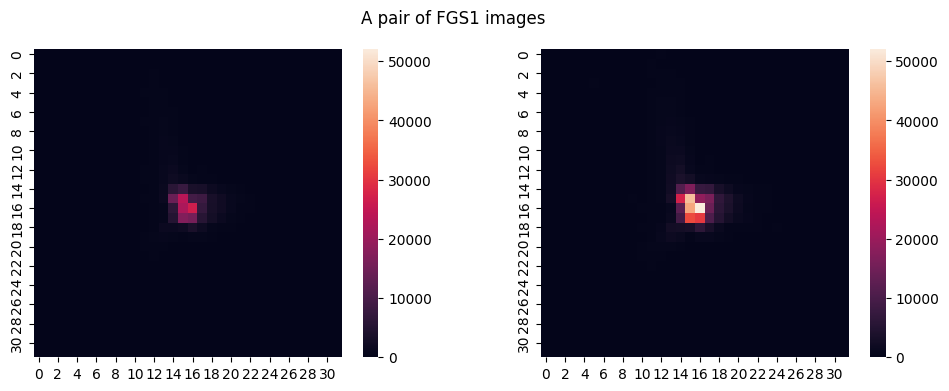

In [18]:
# 取100468857号行星0时刻和1时刻的FGS1数据进行比较
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(f_signal.iloc[0].values.reshape(32, 32), ax=ax1, vmin=0, vmax=52000)
ax1.set_aspect('equal')
sns.heatmap(f_signal.iloc[1].values.reshape(32, 32), ax=ax2, vmin=0, vmax=52000)
ax2.set_aspect('equal')
plt.suptitle('A pair of FGS1 images')
plt.show()

观察时序变化

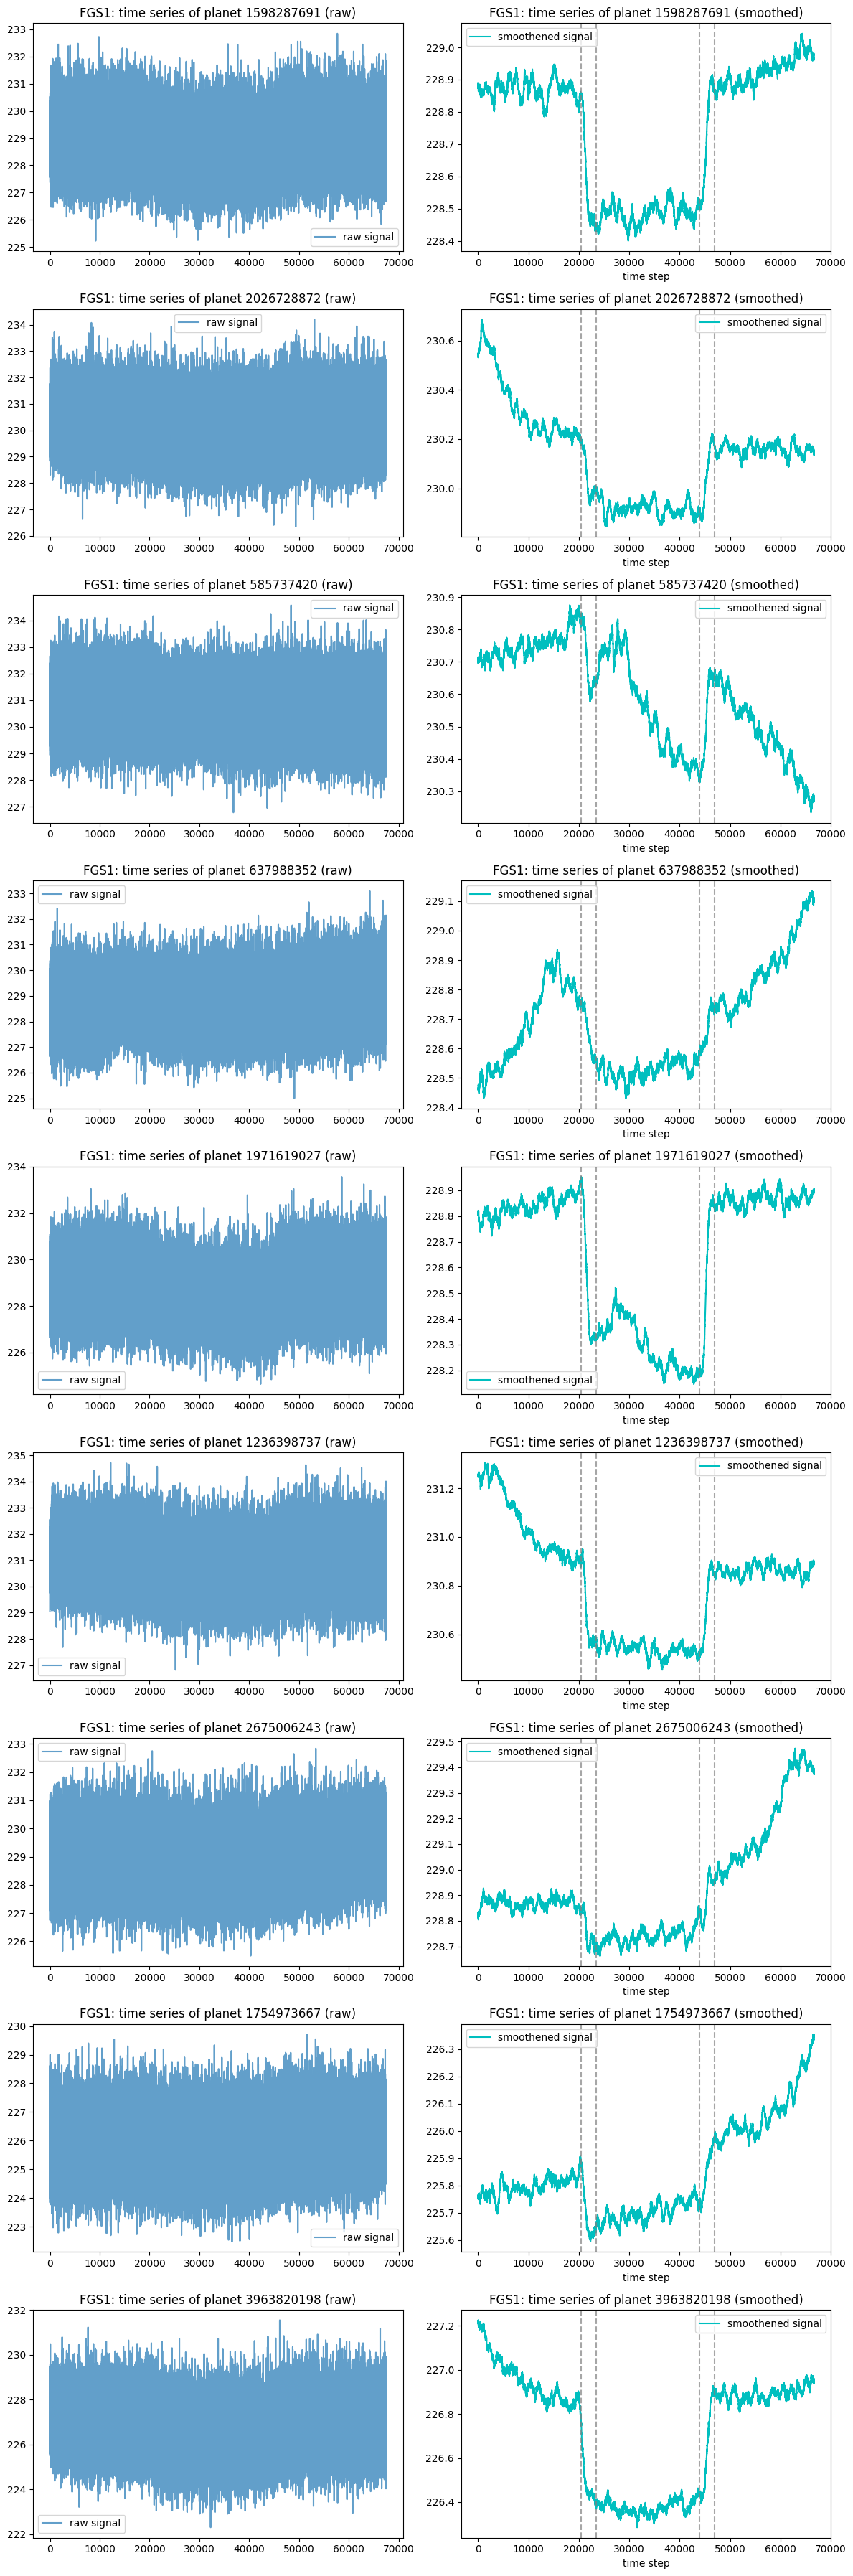

In [20]:
# 定义滑动窗口平滑函数
def smooth_signal(signal, window=800):
    """
    使用滑动窗口平滑信号。
    参数：
    - signal: ndarray, 累积信号。
    - window: int, 滑动窗口大小。
    返回：
    - smooth_signal: ndarray, 平滑后的信号。
    """
    return (signal[window:] - signal[:-window]) / window

# 定义处理单个行星信号的函数
def process_planet_signal(planet_id):
    """
    加载并处理指定行星的 FGS1 数据。
    参数：
    - planet_id: int, 行星 ID。
    返回：
    - net_signal: ndarray, 奇偶帧差分信号。
    - smooth_signal: ndarray, 平滑后的信号。
    """
    f_signal = pd.read_parquet(f'./input/ariel-data-challenge-2024/train/{planet_id}/FGS1_signal.parquet')
    mean_signal = f_signal.values.mean(axis=1)  # 直接对每帧图像取平均值
    net_signal = mean_signal[1::2] - mean_signal[0::2]  # 奇数帧 - 偶数帧
    cum_signal = net_signal.cumsum()  # 累积信号
    smoothed_signal = smooth_signal(cum_signal)  # 平滑信号
    return net_signal, smoothed_signal


# 创建子图，根据行星数量动态调整布局
num_planets = len(random_ids)
fig, axes = plt.subplots(num_planets, 2, figsize=(12, 4 * num_planets))
if num_planets == 1:
    axes = [axes]  # 保证 axes 是二维列表形式，适配后续循环

# 遍历每个随机行星 ID
for i, planet_id in enumerate(random_ids):
    ax_signal, ax_smooth = axes[i]

    # 处理每个行星的信号
    net_signal, smoothed_signal = process_planet_signal(planet_id)

    # 绘制原始信号
    ax_signal.set_title(f'FGS1: time series of planet {planet_id} (raw)')
    ax_signal.plot(net_signal, label='raw signal', alpha=0.7)
    ax_signal.legend()

    # 绘制平滑信号
    ax_smooth.set_title(f'FGS1: time series of planet {planet_id} (smoothed)')
    ax_smooth.plot(smoothed_signal, color='c', label='smoothened signal')
    ax_smooth.legend()
    ax_smooth.set_xlabel('time step')

    # 可选：标注特定的时间点（这里根据 net_signal 自动计算关键点）
    for time_step in [20500, 23500, 44000, 47000]:  # 示例特定时间点
        ax_smooth.axvline(time_step, color='gray', linestyle='--', alpha=0.7)

# 调整布局并显示图像
plt.tight_layout()
plt.show()